<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/CVAE_MNIST_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys

#### Import Data (and select part of it only)

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

pick_class = True
crop_input = False
class_to_pick = 2
data_inputs = 1000

def pick_class(x_train, y_train, class_n):
    new_x_train=x_train[y_train == class_n]
    new_y_train=y_train[y_train == class_n]
    return new_x_train, new_y_train

if pick_class:
    x_train, y_train = pick_class(x_train, y_train, class_to_pick)

if crop_input:
    x_train = x_train[0:data_inputs]
    y_train = y_train[0:data_inputs]

#### Define Data Size and Classes

In [0]:
# INPUT DATA
class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1

N_train = len(y_train)
N_test = len(y_test)
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

#### Plot images from set (random or in order)

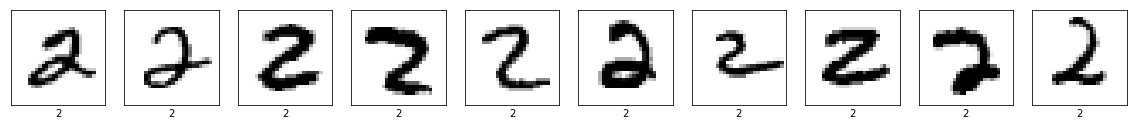

In [72]:
def plot_images(x_train, y_train, figures_to_plot=10, pick_random=False, include_labels=True):
    n_rows = np.ceil(figures_to_plot/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

plot_images(x_train, y_train, 10)

#### Pre-Proces Data

(5958, 28, 28)


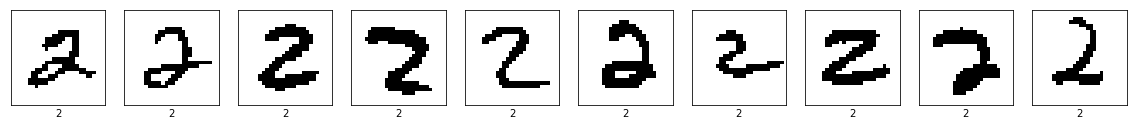

In [73]:
train_images = x_train/input_range
test_images = x_test/input_range

def set_pixels_binary(images):
    images[images >= 0.5] = 1.0
    images[images < 0.5] = 0.0
    return images

train_images = set_pixels_binary(train_images)
test_images = set_pixels_binary(test_images)
train_labels = y_train
test_labels = y_test

print(np.shape(train_images))
plot_images(train_images, train_labels, 10)

train_images = train_images.reshape(N_train, image_shape[0], image_shape[1], N_image_channels).astype('float32')
test_images = test_images.reshape(N_test, image_shape[0], image_shape[1], N_image_channels).astype('float32')

#### Create Dataset

In [0]:
batch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(N_train).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(N_test).batch(batch_size)

#### Create Variational Autoencoder (VAE) Model

In [75]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=24*24*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(24, 24, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3)),
                          ])
    @tf.function
    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
    
    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

z_size = 30
model = CVAE(z_size)
model.encoder_nn.summary()
model.decoder_nn.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
flatten_10 (Flatten)         (None, 36864)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 60)                2211900   
Total params: 2,230,716
Trainable params: 2,230,716
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 36864)             1142784   
____________________

#### Define the loss function 

In [0]:
@tf.function
def calculate_ELBO(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO #Negative because we want to maximise it

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)
        
@tf.function
def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

In [0]:
#### Generate random image from latent vector

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot=figures_to_plot, include_labels=False)

#### Train the data

Epoch 1 progress (%): 100.0
Train ELBO: -279.2157897949219;
Test ELBO: -239.12338256835938;
Generated images:


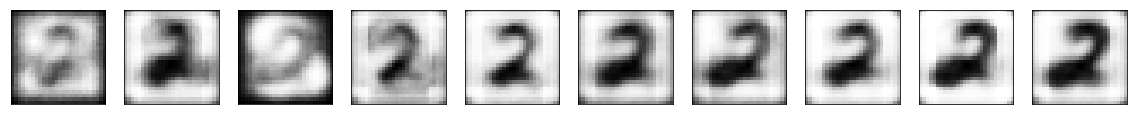

Epoch 2 progress (%): 100.0
Train ELBO: -221.32659912109375;
Test ELBO: -212.59487915039062;
Generated images:


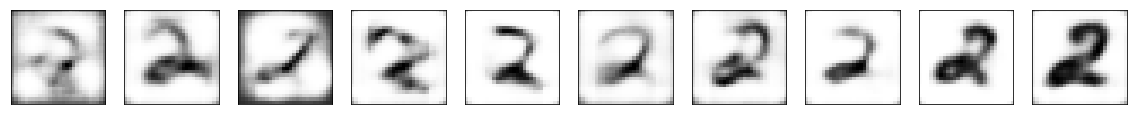

Epoch 3 progress (%): 100.0
Train ELBO: -189.36154174804688;
Test ELBO: -197.46063232421875;
Generated images:


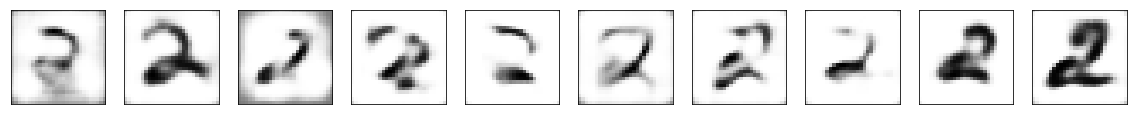

Epoch 4 progress (%): 100.0
Train ELBO: -169.02957153320312;
Test ELBO: -187.04884338378906;
Generated images:


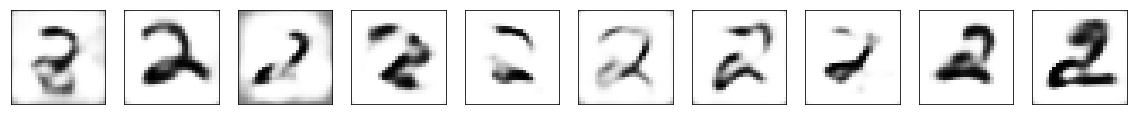

Epoch 5 progress (%): 100.0
Train ELBO: -155.06881713867188;
Test ELBO: -179.0792999267578;
Generated images:


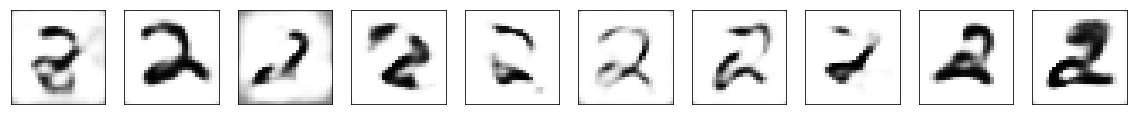

Epoch 6 progress (%): 100.0
Train ELBO: -144.93643188476562;
Test ELBO: -173.08627319335938;
Generated images:


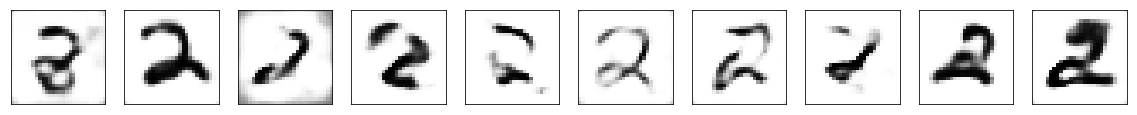

Epoch 7 progress (%): 100.0
Train ELBO: -137.24314880371094;
Test ELBO: -168.57806396484375;
Generated images:


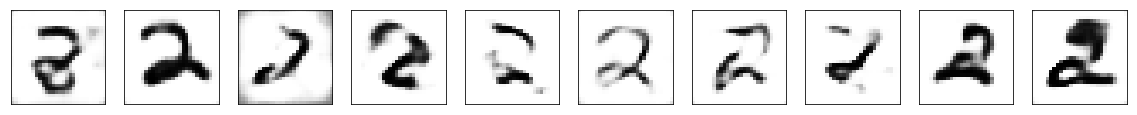

Epoch 8 progress (%): 100.0
Train ELBO: -131.21234130859375;
Test ELBO: -164.84942626953125;
Generated images:


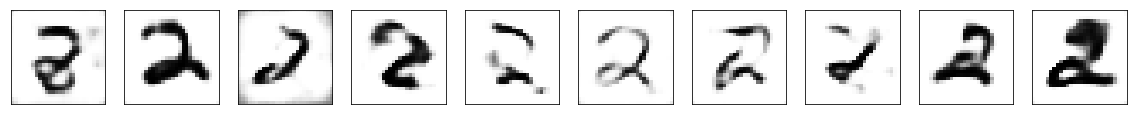

Epoch 9 progress (%): 100.0
Train ELBO: -126.32665252685547;
Test ELBO: -162.05111694335938;
Generated images:


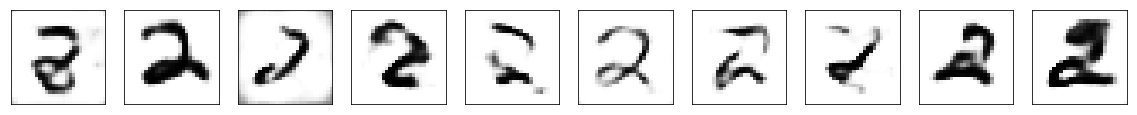

Epoch 10 progress (%): 100.0
Train ELBO: -122.23247528076172;
Test ELBO: -159.72850036621094;
Generated images:


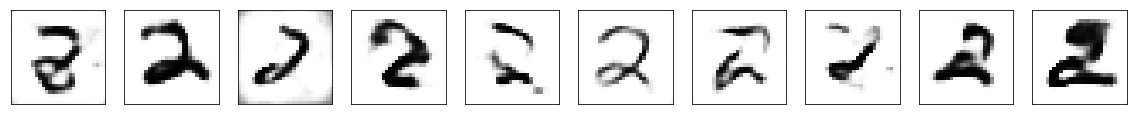

Epoch 11 progress (%): 100.0
Train ELBO: -118.78593444824219;
Test ELBO: -157.83642578125;
Generated images:


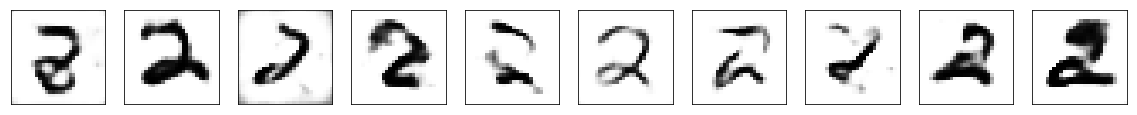

Epoch 12 progress (%): 100.0
Train ELBO: -115.83171844482422;
Test ELBO: -156.2285614013672;
Generated images:


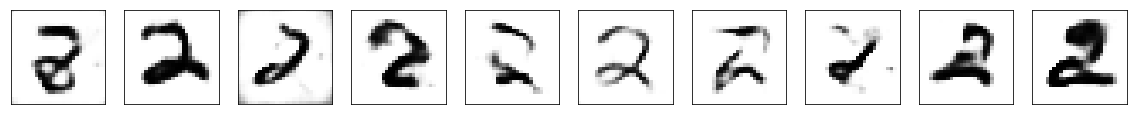

Epoch 13 progress (%): 100.0
Train ELBO: -113.25527954101562;
Test ELBO: -155.0240478515625;
Generated images:


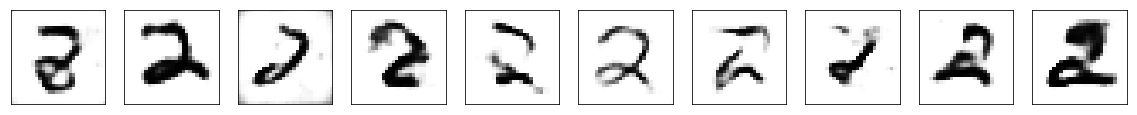

Epoch 14 progress (%): 100.0
Train ELBO: -110.9819564819336;
Test ELBO: -153.90879821777344;
Generated images:


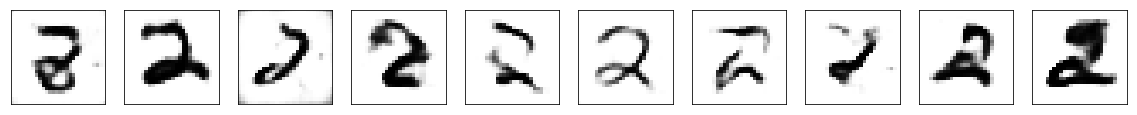

Epoch 15 progress (%): 100.0
Train ELBO: -108.94979095458984;
Test ELBO: -152.83897399902344;
Generated images:


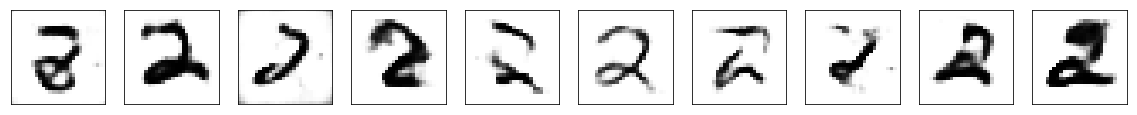

Epoch 16 progress (%): 100.0
Train ELBO: -107.13848114013672;
Test ELBO: -152.16136169433594;
Generated images:


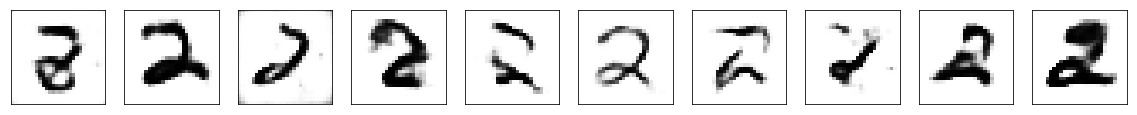

Epoch 17 progress (%): 100.0
Train ELBO: -105.48770904541016;
Test ELBO: -151.55862426757812;
Generated images:


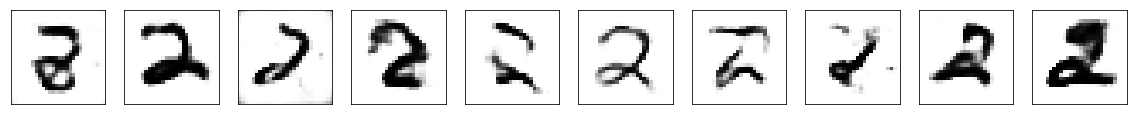

Epoch 18 progress (%): 100.0
Train ELBO: -103.97615814208984;
Test ELBO: -151.0366668701172;
Generated images:


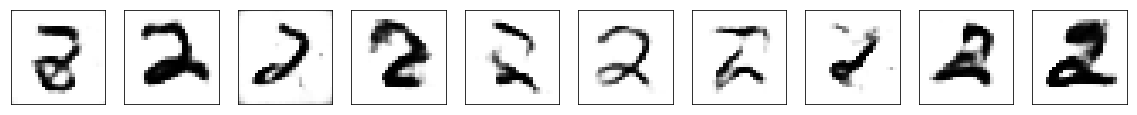

Epoch 19 progress (%): 100.0
Train ELBO: -102.59783935546875;
Test ELBO: -150.65408325195312;
Generated images:


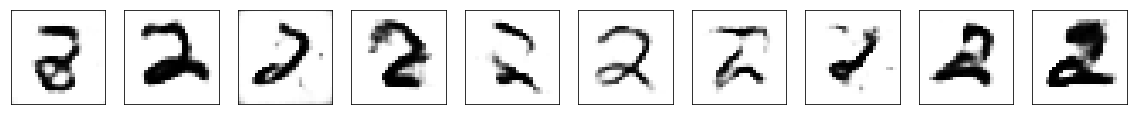

Epoch 20 progress (%): 100.0
Train ELBO: -101.32760620117188;
Test ELBO: -150.40869140625;
Generated images:


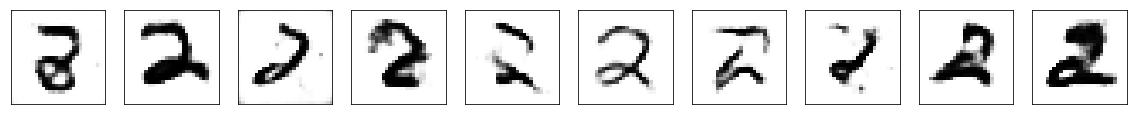

Epoch 21 progress (%): 100.0
Train ELBO: -100.14195251464844;
Test ELBO: -150.0869903564453;
Generated images:


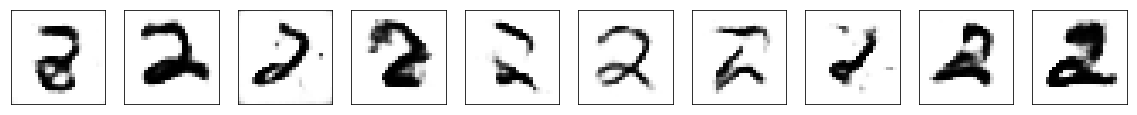

Epoch 22 progress (%): 100.0
Train ELBO: -99.03765106201172;
Test ELBO: -149.92324829101562;
Generated images:


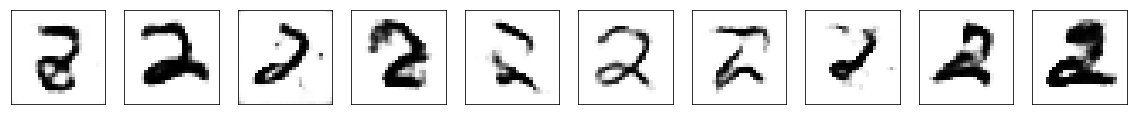

Epoch 23 progress (%): 100.0
Train ELBO: -98.00226593017578;
Test ELBO: -149.74708557128906;
Generated images:


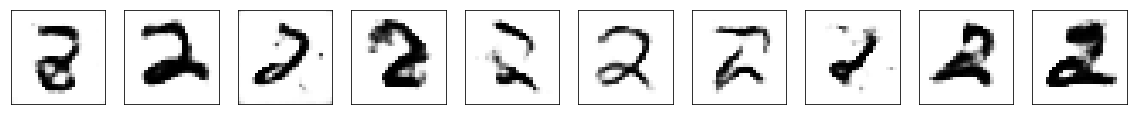

Epoch 24 progress (%): 100.0
Train ELBO: -97.04344940185547;
Test ELBO: -149.66055297851562;
Generated images:


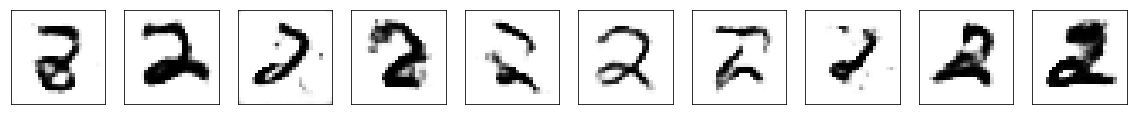

Epoch 25 progress (%): 100.0
Train ELBO: -96.1301040649414;
Test ELBO: -149.73779296875;
Generated images:


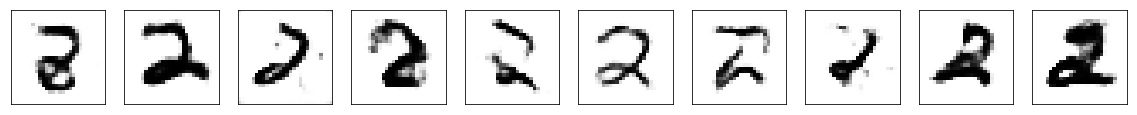

Epoch 26 progress (%): 100.0
Train ELBO: -95.26923370361328;
Test ELBO: -149.81570434570312;
Generated images:


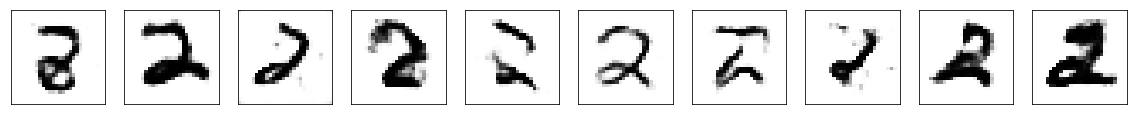

Epoch 27 progress (%): 100.0
Train ELBO: -94.46021270751953;
Test ELBO: -149.849609375;
Generated images:


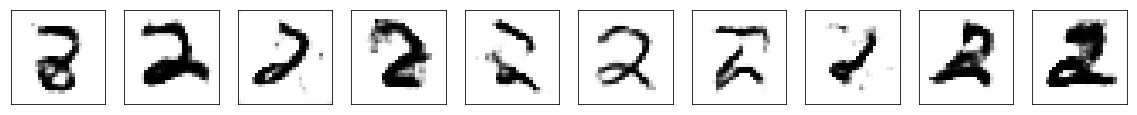

Epoch 28 progress (%): 100.0
Train ELBO: -93.68901824951172;
Test ELBO: -149.902587890625;
Generated images:


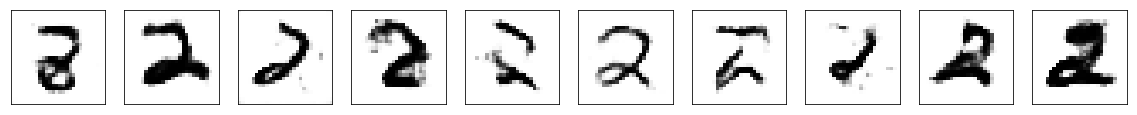

Epoch 29 progress (%): 100.0
Train ELBO: -92.95637512207031;
Test ELBO: -150.05038452148438;
Generated images:


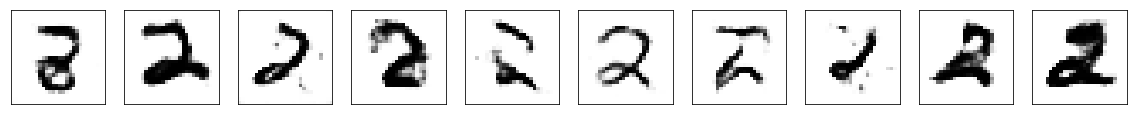

Epoch 30 progress (%): 100.0
Train ELBO: -92.25570678710938;
Test ELBO: -150.30931091308594;
Generated images:


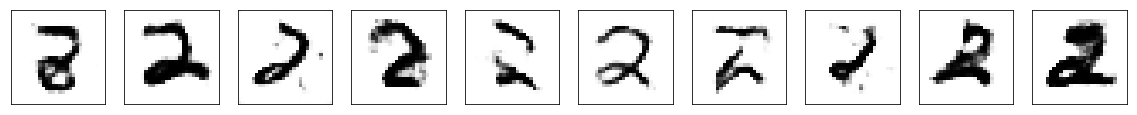

In [82]:
epochs = 30
plots_per_epoch = 10
z_random = tf.random.normal(shape=[plots_per_epoch, z_size])

for epoch in range(epochs):
    for i, train_x in enumerate(train_dataset): 
        sys.stdout.write('\r'+'Epoch {} progress (%): {}'.format(epoch+1,100*(i+1)/(np.ceil(N_train/batch_size))))
        sys.stdout.flush()
        train_step(model, train_x, optimizer)

    for i, test_x in enumerate(test_dataset):
        test_step(model, test_x, optimizer)
    
    print('\nTrain ELBO: {};\nTest ELBO: {};\nGenerated images:'.format(-train_loss.result(), -test_loss.result()))
    
    generate_images(model, z_random, plots_per_epoch)

In [0]:
#### Reconstruct image

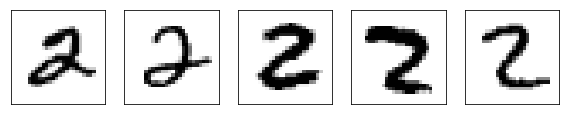

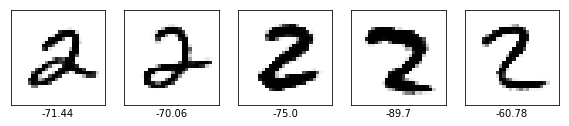

In [86]:
def reconstruct_images(range1, range2):
    images_to_pick = range(range1,range2)
    y = x_train[images_to_pick]
    x = train_images[images_to_pick]
    loss = np.empty([len(images_to_pick)])

    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    for i in range(len(images_to_pick)):
        loss[i] = calculate_ELBO(model,x[i:i+1])

    loss = loss.astype('float16')
    plot_images(y, _, figures_to_plot=len(images_to_pick), include_labels=False)
    plot_images(pixel_prob, -loss, figures_to_plot=len(images_to_pick), include_labels=True)

reconstruct_images(0,5)
